### Importing libraries

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os

import cv2

import albumentations as albu
from albumentations import Compose, ShiftScaleRotate, Resize
from albumentations.pytorch import ToTensor


from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import classification_report

import shutil

import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.metrics import categorical_accuracy

from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau, 
                                        ModelCheckpoint, CSVLogger, LearningRateScheduler)
from tensorflow.keras.applications.mobilenet import MobileNet

C:\Users\jayak\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\jayak\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\jayak\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\jayak\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
IMAGE_CHANNELS = 3

### Data directory

In [3]:
os.listdir('C:\\Users\\jayak\\Rice leaf disease')

['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

### User defined functions

In [4]:
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### Data preparation

In [5]:
leaf_smut_list = os.listdir('C:\\Users\\jayak\\Rice leaf disease\\Leaf smut')

In [6]:
Bacterial_leaf_blight_list = os.listdir('C:\\Users\\jayak\\Rice leaf disease\\Bacterial leaf blight')

In [7]:
Brown_spot_list = os.listdir('C:\\Users\\jayak\\Rice leaf disease\\Brown spot')

In [8]:
len(leaf_smut_list)

39

In [9]:
len(Bacterial_leaf_blight_list)

40

In [10]:
len(Brown_spot_list)

40

In [11]:
df_leaf_smut = pd.DataFrame(leaf_smut_list, columns=['image'])
df_leaf_smut['target'] = 'leaf_smut'

df_brown_spot = pd.DataFrame(Brown_spot_list, columns=['image'])
df_brown_spot['target'] = 'brown_spot'

df_bacterial_leaf_blight = pd.DataFrame(Bacterial_leaf_blight_list, columns=['image'])
df_bacterial_leaf_blight['target'] = 'bacterial_leaf_blight'

df_leaf_smut_val = df_leaf_smut.sample(n=5, random_state=101)
df_brown_spot_val = df_brown_spot.sample(n=5, random_state=101)
df_bacterial_leaf_blight_val = df_bacterial_leaf_blight.sample(n=5, random_state=101)


print(len(df_leaf_smut_val))
print(len(df_brown_spot_val))
print(len(df_bacterial_leaf_blight_val))

5
5
5


In [12]:
val_list = list(df_leaf_smut_val['image'])
df_leaf_smut_train = df_leaf_smut[~df_leaf_smut['image'].isin(val_list)] # ~ means notin
val_list = list(df_brown_spot_val['image'])
df_brown_spot_train = df_brown_spot[~df_brown_spot['image'].isin(val_list)] # ~ means notin
val_list = list(df_bacterial_leaf_blight_val['image'])
df_bacterial_leaf_blight_train = \
df_bacterial_leaf_blight[~df_bacterial_leaf_blight['image'].isin(val_list)] # ~ means notin

print(len(df_leaf_smut_train))
print(len(df_brown_spot_train))
print(len(df_bacterial_leaf_blight_train))

34
35
35


### Creating train and validation datasets

In [13]:
df_data = pd.concat([df_leaf_smut, df_brown_spot, df_bacterial_leaf_blight], axis=0).reset_index(drop=True)

df_train = \
pd.concat([df_leaf_smut_train, df_brown_spot_train, df_bacterial_leaf_blight_train], axis=0).reset_index(drop=True)

df_val = \
pd.concat([df_leaf_smut_val, df_brown_spot_val, df_bacterial_leaf_blight_val], axis=0).reset_index(drop=True)

df_data = shuffle(df_data)
df_train = shuffle(df_train)
df_val = shuffle(df_val)

print(df_data.shape)
print(df_train.shape)
print(df_val.shape)

(119, 2)
(104, 2)
(15, 2)


In [14]:
df_data['target'].value_counts()

brown_spot               40
bacterial_leaf_blight    40
leaf_smut                39
Name: target, dtype: int64

In [15]:
df_train['target'].value_counts()

brown_spot               35
bacterial_leaf_blight    35
leaf_smut                34
Name: target, dtype: int64

In [16]:
df_val['target'].value_counts()

bacterial_leaf_blight    5
leaf_smut                5
brown_spot               5
Name: target, dtype: int64

### Encoding target variable

In [17]:
val_len = len(df_val)
train_len = len(df_train)
df_combined =  pd.concat(objs=[df_val, df_train], axis=0).reset_index(drop=True)

# create the dummy variables
df_combined = pd.get_dummies(df_combined, columns=['target'])

# separate the train and val sets
df_val = df_combined[:val_len]
df_train = df_combined[val_len:]


print(df_train.shape)
print(df_val.shape)

(104, 4)
(15, 4)


In [18]:
df_combined.head()

,image,target_bacterial_leaf_blight,target_brown_spot,target_leaf_smut
0,DSC_0121.jpg,0,1,0
1,DSC_0302.JPG,0,1,0
2,DSC_0700.jpg,1,0,0
3,DSC_0384.JPG,1,0,0
4,DSC_0504.jpg,0,0,1


In [19]:
df_train.head()

,image,target_bacterial_leaf_blight,target_brown_spot,target_leaf_smut
15,DSC_0329.jpg,0,1,0
16,DSC_0506.jpg,0,0,1
17,DSC_0315.jpg,0,0,1
18,DSC_0316.JPG,0,0,1
19,DSC_0370.jpg,1,0,0


In [20]:
df_val.head()

,image,target_bacterial_leaf_blight,target_brown_spot,target_leaf_smut
0,DSC_0121.jpg,0,1,0
1,DSC_0302.JPG,0,1,0
2,DSC_0700.jpg,1,0,0
3,DSC_0384.JPG,1,0,0
4,DSC_0504.jpg,0,0,1


### All images in one directory

In [21]:
image_dir = 'image_dir'
os.mkdir(image_dir)

In [22]:
import shutil
for fname in leaf_smut_list:
    path='C:\\Users\\jayak\\Rice leaf disease\\Leaf smut'
    src = os.path.join(path, fname)
    dst = os.path.join(image_dir, fname)
    shutil.copyfile(src, dst)
    
for fname in Bacterial_leaf_blight_list:
    path='C:\\Users\\jayak\\Rice leaf disease\\Bacterial leaf blight'
    src = os.path.join(path, fname)
    dst = os.path.join(image_dir, fname)
    shutil.copyfile(src, dst)
    
for fname in Brown_spot_list:
    path='C:\\Users\\jayak\\Rice leaf disease\\Brown spot'
    src = os.path.join(path, fname)
    dst = os.path.join(image_dir, fname)
    shutil.copyfile(src, dst)
        
len(os.listdir('image_dir'))

119

### Data augmentations

In [23]:
def augment_image(augmentation, image):
    
    """
    Uses the Albumentations library.
    
    Inputs: 
    1. augmentation - this is the instance of type of augmentation to do 
    e.g. aug_type = HorizontalFlip(p=1) 
    # p=1 is the probability of the transform being executed.
    
    2. image - image with shape (h,w)
    
    Output:
    Augmented image as a numpy array.
    
    """
    # get the transform as a dict
    aug_image_dict =  augmentation(image=image)
    # retrieve the augmented matrix of the image
    image_matrix = aug_image_dict['image']
    
    
    return image_matrix

In [24]:
aug_types = albu.Compose([
            albu.HorizontalFlip(),
             albu.OneOf([
                albu.HorizontalFlip(),
                albu.VerticalFlip(),
                ], p=0.8),
            albu.OneOf([
                albu.RandomContrast(),
                albu.RandomGamma(),
                albu.RandomBrightness(),
                ], p=0.3),
            albu.OneOf([
                albu.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                albu.GridDistortion(),
                albu.OpticalDistortion(distort_limit=2, shift_limit=0.5),
                ], p=0.3),
            albu.ShiftScaleRotate()
            ])

### Testing transformations

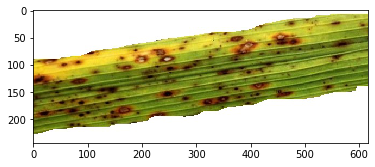

In [25]:
path = 'image_dir/'
image_list = os.listdir('image_dir')

fname = image_list[1]
image_path = path + fname

image = plt.imread(image_path)
plt.imshow(image)

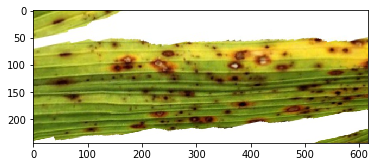

In [26]:
aug_image = augment_image(aug_types, image)

plt.imshow(aug_image)

### Creating data generators

In [27]:
def train_generator(batch_size=8):
    
    while True:
        for df in pd.read_csv('df_train.csv.gz', chunksize=batch_size):
            image_id_list = list(df['image'])
            X_train = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
            for i in range(0, len(image_id_list)):
                image_id = image_id_list[i]
                path = 'image_dir/' + image_id
                image = cv2.imread(path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
                cols = ['target_bacterial_leaf_blight', 'target_brown_spot', 'target_leaf_smut']
                y_train = df[cols]
                y_train = np.asarray(y_train) 
                aug_image = augment_image(aug_types, image)
                X_train[i] = aug_image
            X_train = X_train/255
            yield X_train, y_train


In [28]:
train_gen = train_generator(batch_size=8)
X_train, y_train = next(train_gen)

print(X_train.shape)
print(y_train.shape)

(8, 224, 224, 3)
(8, 3)


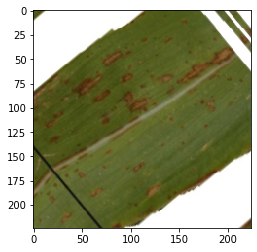

In [29]:
image = X_train[0,:,:,:]
plt.imshow(image)

In [30]:
def val_generator(batch_size=5):
    
    while True:
        for df in pd.read_csv('df_val.csv.gz', chunksize=batch_size):
            image_id_list = list(df['image'])
            X_val = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
            for i in range(0, len(image_id_list)):
                image_id = image_id_list[i]
                path = 'image_dir/' + image_id
                image = cv2.imread(path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
                cols = ['target_bacterial_leaf_blight', 'target_brown_spot', 'target_leaf_smut']
                y_val = df[cols]
                y_val = np.asarray(y_val) 
            X_val = X_val/255

            yield X_val, y_val

In [31]:
val_gen = val_generator(batch_size=5)
X_val, y_val = next(val_gen)

print(X_val.shape)
print(y_val.shape)

(5, 224, 224, 3)
(5, 3)


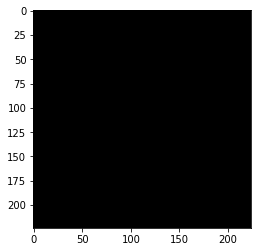

In [32]:
image = X_val[0,:,:,:]
plt.imshow(image)

In [33]:
def test_generator(batch_size=1):
    
    while True:
        for df in pd.read_csv('df_val.csv.gz', chunksize=batch_size):
            image_id_list = list(df['image'])
            X_test = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
            for i in range(0, len(image_id_list)):
                image_id = image_id_list[i]
                path = 'image_dir/' + image_id
                image = cv2.imread(path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
                X_test[i] = image
            X_test = X_test/255

            yield X_test

In [34]:
test_gen = test_generator(batch_size=1)
X_test = next(test_gen)

print(X_test.shape)

(1, 224, 224, 3)


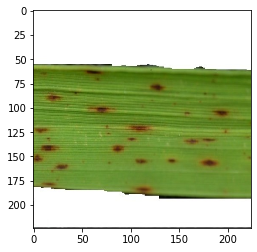

In [35]:
image = X_test[0,:,:,:]
plt.imshow(image)

### Modelling

In [36]:


model = MobileNet(weights='imagenet')
x = model.layers[-2].output
predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=model.input, outputs=predictions)

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________

In [37]:
TRAIN_BATCH_SIZE = 8
VAL_BATCH_SIZE = 5

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = TRAIN_BATCH_SIZE
val_batch_size = VAL_BATCH_SIZE
train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [38]:
train_gen = train_generator(batch_size=TRAIN_BATCH_SIZE)
val_gen = val_generator(batch_size=VAL_BATCH_SIZE)

model.compile(Adam(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [39]:
filepath = "C:\\Users\\jayak\\Rice leaf disease\\model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')
log_fname = 'training_log.csv'
csv_logger = CSVLogger(filename=log_fname,
                       separator=',',
                       append=False)

callbacks_list = [checkpoint, csv_logger]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=10, 
                              validation_data=val_gen, validation_steps=val_steps,
                             verbose=1,
                             callbacks=callbacks_list)

Epoch 1/10
13/13 [==============================] - 58s 4s/step - loss: 2.0075 - acc: 0.5288 - val_loss: 1.9581 - val_acc: 0.3333
Epoch 2/10
13/13 [==============================] - 43s 3s/step - loss: 0.9454 - acc: 0.7500 - val_loss: 2.8546 - val_acc: 0.3333
Epoch 3/10
13/13 [==============================] - 43s 3s/step - loss: 0.5454 - acc: 0.8173 - val_loss: 2.1091 - val_acc: 0.3333
Epoch 4/10
13/13 [==============================] - 43s 3s/step - loss: 0.4150 - acc: 0.9038 - val_loss: 1.5974 - val_acc: 0.3333
Epoch 5/10
13/13 [==============================] - 44s 3s/step - loss: 0.2645 - acc: 0.8942 - val_loss: 1.3917 - val_acc: 0.3333
Epoch 6/10
13/13 [==============================] - 43s 3s/step - loss: 0.1908 - acc: 0.9615 - val_loss: 1.3180 - val_acc: 0.3333
Epoch 7/10
13/13 [==============================] - 43s 3s/step - loss: 0.3835 - acc: 0.9038 - val_loss: 1.2804 - val_acc: 0.3333
Epoch 8/10
13/13 [==============================] - 43s 3s/step - loss: 0.2993 - acc: 0.87

In [40]:
train_log = pd.read_csv('training_log.csv')

train_log.head()

,epoch,acc,loss,val_acc,val_loss
0,0,0.528846,2.007549,0.333333,1.958092
1,1,0.750000,0.945363,0.333333,2.854599
2,2,0.817308,0.545374,0.333333,2.109060
3,3,0.903846,0.414968,0.333333,1.597444
4,4,0.894231,0.264496,0.333333,1.391749


### Model evaluation

In [41]:

val_gen = val_generator(batch_size=1)

val_loss, val_acc = \
model.evaluate_generator(val_gen, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_acc:', val_acc)

val_loss: 2.2471792648235955
val_acc: 0.33333334


### Predictions

In [42]:
test_gen = test_generator(batch_size=1)

preds = model.predict_generator(test_gen, steps=len(df_val), verbose=1)

15/15 [==============================] - 2s 118ms/step


In [43]:
y_pred = np.argmax(preds, axis=1)

y_pred

array([2, 1, 1, 0, 0, 0, 0, 2, 1, 1, 1, 0, 2, 1, 1], dtype=int64)

In [44]:
cols = ['target_bacterial_leaf_blight', 'target_brown_spot', 'target_leaf_smut']
y_true = df_val[cols]
y_true = np.asarray(y_true) 

y_true = np.argmax(y_true, axis=1)

y_true

array([1, 1, 0, 0, 2, 0, 2, 2, 2, 0, 1, 1, 0, 1, 2], dtype=int64)

In [45]:

print(y_pred)
print(y_true)

[2 1 1 0 0 0 0 2 1 1 1 0 2 1 1]
[1 1 0 0 2 0 2 2 2 0 1 1 0 1 2]


### Confusion matrix

In [46]:
from sklearn.metrics import confusion_matrix
import itertools

cm = confusion_matrix(y_true, y_pred)

Confusion matrix, without normalization
[[2 2 1]
 [1 3 1]
 [2 2 1]]


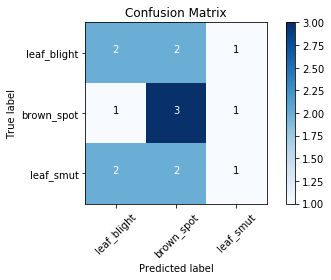

In [47]:
cm_plot_labels = ['leaf_blight', 'brown_spot', 'leaf_smut']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

### Classification report

In [48]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=['bacterial_leaf_blight', 'brown_spot', 'leaf_smut'])

print(report)

                       precision    recall  f1-score   support

bacterial_leaf_blight       0.40      0.40      0.40         5
           brown_spot       0.43      0.60      0.50         5
            leaf_smut       0.33      0.20      0.25         5

             accuracy                           0.40        15
            macro avg       0.39      0.40      0.38        15
         weighted avg       0.39      0.40      0.38        15



In [49]:
shutil.rmtree('image_dir')